# In this demo

This demo presents the design and functionality of `Signal`s, which are the core objects for representing coefficients in models. `Signal`s are structured to represent the mathematical formula:
$$s(t) = Re[f(t)e^{i(2 \pi \nu t + \phi)}],$$
where
- $f(t)$ is a complex-valued envelope,
- $\nu$ is the carrier frequency, and
- $\phi$ is the phase.

Using this formula as a basis for the representation of `Signal`s is motivated by:
- This is a very common representation when modelling control sequences in quantum systems; in particular, for representing signals whose Fourier spectrum is localized about a particular frequency.
- It is general; even when the previous point is not immediately applicable, the full generality of the envelope $f(t)$ allows for specification of arbitrary real-valued functions.

Taking the above as a given, the design for `Signal`s is further motivated to facilitate different modes of operation:
- Completely general envelopes: The user specifies $f(t)$ as python-callable function. 
    - This allows for arbitrary signal definitions, including continuous functions.
- Piecewise constant, or *discrete* envelopes, in which $f(t)$ is a piecewise constant function of time. 
    - This allows for sample-based construction and computation on `Signal`s. 
    - Signal processing and evaluation can be performed purely as collective array-based operations, which is more efficient than the function-based products required in the fully general case.

In [1]:
import numpy as np
from qiskit_dynamics.signals import Signal, DiscreteSignal, SignalList, DiscreteSignalSum
from matplotlib import pyplot as plt

%matplotlib inline

# 1. `Signal` and its subclasses

## 1.1 `Signal`

The most general signal object takes the envelope as a python callable function.

In [2]:
sig = Signal(envelope=lambda t: t**2, carrier_freq=2.)

We can evaluate the signal by directly calling the object, or we can evaluate its complex envelope or full complex value.

In [3]:
print(sig(1.1))
print(sig.envelope(1.1))
print(sig.complex_value(1.1))

0.373910563193685
1.2100000000000002
(0.373910563193685+1.1507783847171364j)


The evaluation functions are all setup for vectorized evaluation, and we assume that the user-specified envelope is vectorized. If not, it can be vectorized using `numpy.vectorize`.

In [4]:
t_vals = np.array([0.1, 1.1])
print(sig(t_vals))
print(sig.envelope(t_vals))
print(sig.complex_value(t_vals))

[0.00309017 0.37391056]
[0.01 1.21]
[0.00309017+0.00951057j 0.37391056+1.15077838j]


We can also plot the evaluation functions.

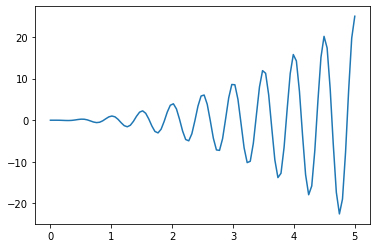

In [5]:
# plot the signal
sig.draw(0, 5, 100)

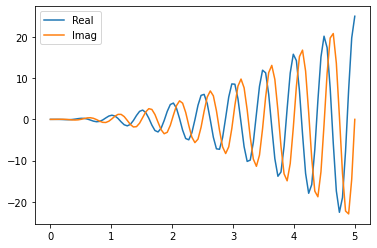

In [6]:
# plot the complex value
sig.draw(0, 5, 100, function='complex_value')

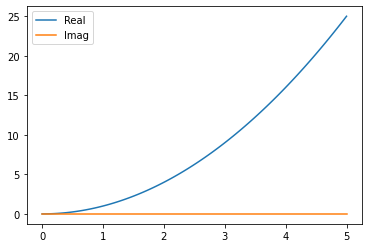

In [7]:
# plot just the envelope
sig.draw(0, 5, 100, function='envelope')

## 1.2 Constant `Signal`

This is not a subclass, but an alternate mode of behaviour for `Signal`. Generally a user shouldn't need to do this, but internally, constant values are converted to a `Signal` with constant envelope and zero carrier frequency/phase.

This can be instantiated by passing a numeric value to the constructor of `Signal`.

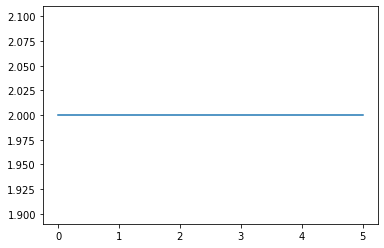

In [8]:
constant = Signal(2.)
constant.draw(0, 5, 100)

In [9]:
constant.is_constant

True

## 1.3 `DiscreteSignal(Signal)`

A `DiscreteSignal` represents a `Signal` whose envelope is piecewise constant, and is specified as an array of samples. 

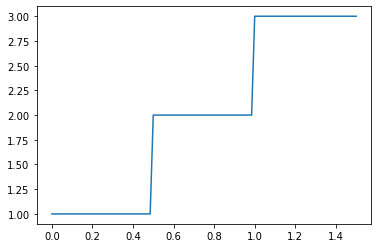

In [10]:
discrete_signal = DiscreteSignal(dt=0.5, samples=[1., 2., 3.])
discrete_signal.draw(0, 1.5, 100)

A `DiscreteSignal` can still have an analog carrier.

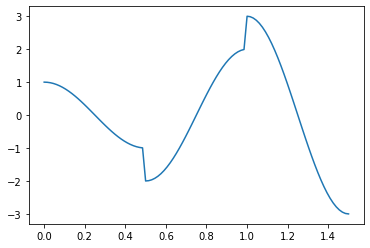

In [11]:
discrete_signal = DiscreteSignal(dt=0.5, samples=[1., 2., 3.], carrier_freq=1.)
discrete_signal.draw(0, 1.5, 100)

# 2. Algebraic operations on `Signal`s

It is natural to add and multiply signals, as these mathematical operations correspond to the behaviour of physical circuit elements. To facilitate this, we introduce the `SignalSum` object, which represents a sum of `Signal`s. The purpose of this class is to allow higher level algebraic operations on `Signal`s while preserving frequency information.

Algebraic operations have been implemented using python dunder methods, so that a user can add and multiply signals using standard python syntax.

## 2.1 Adding general `Signal`s

In [12]:
sig1 = Signal(lambda t: t, carrier_freq=10.)
sig2 = Signal(lambda t: 10 * t, carrier_freq=20.)

# add using standard python syntax 
sig_sum = sig1 + sig2

`sig_sum` is now a `SignalSum` object:

In [13]:
print(type(sig_sum))
str(sig_sum)

<class 'qiskit_dynamics.signals.signals.SignalSum'>


'Signal(carrier_freq=10.0, phase=0.0) + Signal(carrier_freq=20.0, phase=0.0)'

This is a container class storing the original signals in the sum in the `components` attribute:

In [14]:
sig_sum.components

We can interact with this object in the same way as a regular `Signal`, e.g. we can draw it:

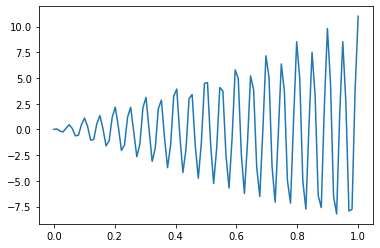

In [15]:
sig_sum.draw(0, 1, 100)

We can produce the same plot by evaluating the individual signals in the sum separately:

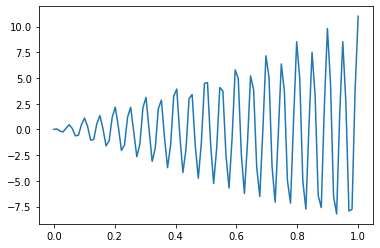

In [16]:
t_vals = np.linspace(0, 1, 100)
plt.plot(t_vals, sig1(t_vals) + sig2(t_vals))

## 2.2 Multiplying signals

Multiplication of signals is implemented via the formula:
$$Re[f(t)e^{i(2 \pi \nu t + \phi)}] \times Re[g(t)e^{i(2 \pi \omega t + \psi)}]
         = Re[\frac{1}{2} f(t)g(t)e^{i(2\pi (\omega + \nu)t + (\phi + \psi))} ]
          + Re[\frac{1}{2} f(t)\overline{g(t)}e^{i(2\pi (\omega - \nu)t + (\phi - \psi))} ].$$
When two signals are multiplied, a `SignalSum` representing the right hand side of the above equation is constructed.

In [17]:
sig_prod = sig1 * sig2
str(sig_prod)

'Signal(carrier_freq=30.0, phase=0.0) + Signal(carrier_freq=-10.0, phase=0.0)'

We see that the above product consists of a sum of signals centred at frequencies `4.0` and `0.0`.

In [18]:
sig_prod(2.) - sig1(2.) * sig2(2.)

0.0

## 2.3 `DiscreteSignalSum` and operations on `DiscreteSignal`s

The previous sections show how addition/multiplication work for general `Signal` s. In the general case, as the envelope is a user-specified function, we can only multiply envelopes as functions. For `DiscreteSignal` s with compatible sample strcuture, we can multiply envelopes as arrays.

In [19]:
discrete_sig1 = DiscreteSignal(dt=1., samples=[1., 2., 3.], carrier_freq=2.)
discrete_sig2 = DiscreteSignal(dt=1., samples=[4j, 5j, 6j], carrier_freq=2.)
discrete_prod = discrete_sig1 * discrete_sig2

In [20]:
print(type(discrete_prod))
str(discrete_prod)

<class 'qiskit_dynamics.signals.signals.DiscreteSignalSum'>


'DiscreteSignal(dt=1.0, carrier_freq=4.0, phase=0.0) + DiscreteSignal(dt=1.0, carrier_freq=0.0, phase=0.0)'

A `DiscreteSignalSum` stores the samples of its constituent components in a single array. 

In [21]:
discrete_prod.samples

Array([[0.+2.j, 0.-2.j],
       [0.+5.j, 0.-5.j],
       [0.+9.j, 0.-9.j]], backend='numpy')

## 2.4 Frequency preservation

One of the benefits of `SignalSum` is that it "preserves frequency information", in the sense that, in applications where each `Signal` has a well-defined central frequency, the algebraic operations will result in `SignalSum`s whose components have well-defined central frequencies. This is useful for operations that require analyzing the frequency components of signals, e.g. the rotating wave approximation.

We can visualize this by examining the FFT of the product of signals above. The product of signals results in a component whose central frequency is at the sum of the frequencies in the product, as well as a component at the difference:

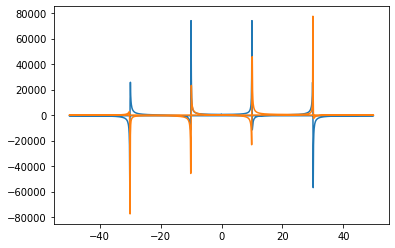

In [22]:
N = 1000
T = 10.
t_vals = np.linspace(0., T, N)
fft_freqs = np.fft.fftfreq(N, T / N)
sig_prod_fft = np.fft.fft(sig_prod(t_vals))
plt.plot(fft_freqs, np.real(sig_prod_fft), fft_freqs, np.imag(sig_prod_fft))

We see components at `30.` and `10.`, as expected. Now, we can look at the FFT of each component of the product:

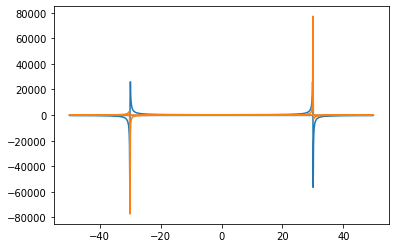

In [23]:
N = 1000
T = 10.
t_vals = np.linspace(0., T, N)
fft_freqs = np.fft.fftfreq(N, T / N)
sig_prod0_fft = np.fft.fft(sig_prod[0](t_vals))
plt.plot(fft_freqs, np.real(sig_prod0_fft), fft_freqs, np.imag(sig_prod0_fft))

We see the first component in the sum is the term whose frequency is at the sum of the product term frequencies.

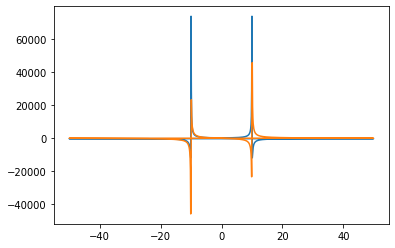

In [24]:
N = 1000
T = 10.
t_vals = np.linspace(0., T, N)
fft_freqs = np.fft.fftfreq(N, T / N)
sig_prod1_fft = np.fft.fft(sig_prod[1](t_vals))
plt.plot(fft_freqs, np.real(sig_prod1_fft), fft_freqs, np.imag(sig_prod1_fft))

The second component in the sum is at the difference.

# 3. IQ mixer via algebraic operations

In [25]:
# define some envelope function
def env(t):
    return t * (1 - t)

w_d = 2.
w_lo = 1.9
w_if = 0.1

I = Signal(env, carrier_freq=w_if, name='I') # envelope times cosine at w_if
Q = Signal(env, carrier_freq=w_if, phase=-np.pi/2, name='Q') # envelope times sine at w_if

slo_I = Signal(1., carrier_freq=w_lo, name='slo_I') # local oscillator for I
slo_Q = Signal(1., carrier_freq=w_lo, phase=-np.pi/2, name='slo_Q') # local oscillator for Q

The IQ output is a sum of two products. Hence, it produces a `SignalSum` with 4 outputs.

In [26]:
IQ_output = (I * slo_I) - (Q * slo_Q)
str(IQ_output)

'Signal(carrier_freq=2.0, phase=0.0) + Signal(carrier_freq=-1.7999999999999998, phase=0.0) + Signal(carrier_freq=2.0, phase=-3.141592653589793) + Signal(carrier_freq=-1.7999999999999998, phase=0.0)'

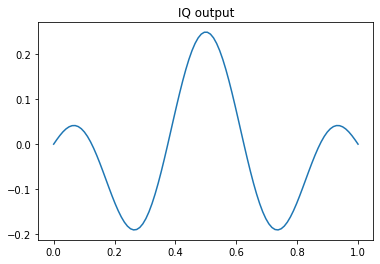

In [27]:
IQ_output.draw(0, 1, 100, title='IQ output')

The $0^{th}$ and $2^{nd}$ terms in the sum are at frequency `2.0`, which we can plot:

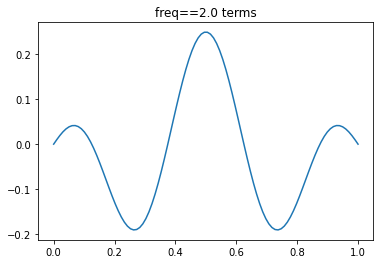

In [28]:
IQ_output[[0, 2]].draw(0, 1, 100, title='freq==2.0 terms')

The $1^{st}$ and $3^{rd}$ terms are at frequency `1.8`:

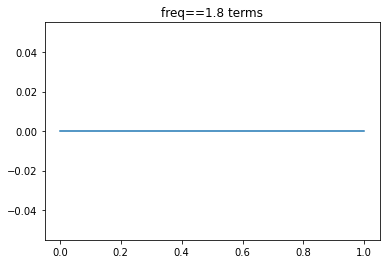

In [29]:
IQ_output[[1, 3]].draw(0, 1, 100, title='freq==1.8 terms')

This demonstrates the cancellation at the lower sideband, with the remaining signal at the upper sideband. When modelling imperfect operation of an IQ mixer, this cancellation may not occur perfectly.

# 4. `SignalList`

A model of a Hamiltonian contains a list of `Signal`s representing coefficients of operators. Each coefficient may be any subclass of `Signal` (including `SignalSum` and `DiscreteSignalSum`). The `SignalList` object is similar to `SignalSum`, in that it stores a list of `Signal`s, but the evaluation functions return an array of each component evaluated separately.

In [30]:
sig_list = SignalList([2. + Signal(lambda t: t, carrier_freq=1.), 
                       1., 
                       DiscreteSignal(dt=1., samples=[1., 2., 3.])])

In [31]:
sig_list(2.)

array([4., 1., 3.])

`SignalList` also contains a helper `drift` property for evaluating the constant part:

In [32]:
sig_list.drift

Array([2., 1., 0.], backend='numpy')

# 5. Transfer functions

In [33]:
from qiskit_dynamics.signals.transfer_functions import Convolution

In [34]:
def gaus(t):
    sigma = 10
    dt = 0.1
    return 2.*dt/np.sqrt(2.*np.pi*sigma**2)*np.exp(-t**2/(2*sigma**2))

In [35]:
ts = np.linspace(0, 100, 1000)
np.sum([gaus(_) for _ in ts])

1.0029894228040142

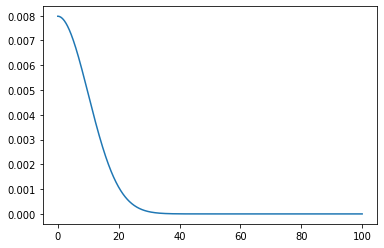

In [36]:
plt.plot(ts, gaus(ts))

In [37]:
convolution = Convolution(gaus)

In [38]:

samples = [0. if t<20. or t > 80. else 1 for t in ts]
piecewise_const = DiscreteSignal(dt=ts[1]-ts[0], samples=samples, carrier_freq=0.0, start_time=0)

Array(0., backend='numpy')

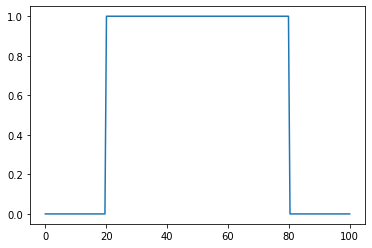

In [39]:
piecewise_const.draw(0, 100, 200)
piecewise_const.carrier_freq

Array(0., backend='numpy')

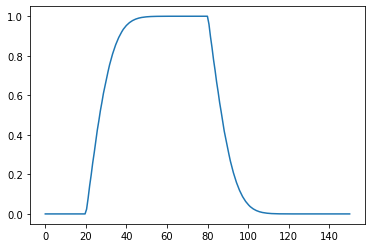

In [40]:
convolved = convolution(piecewise_const)
convolved.draw(0, 150, 200)
convolved.carrier_freq

Array(0.3, backend='numpy')

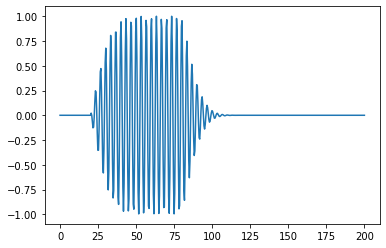

In [41]:
convolved.carrier_freq = 0.3
convolved.draw(0, 200, 500)
convolved.carrier_freq

# 6. Fancy indexing

`Signal` subclasses representing collections of signals can be subscripted in the same manner as a 1d numpy array.

In [42]:
sig_sum = 1. + Signal(lambda t: t) + DiscreteSignal(dt=0.5, samples=[1, 2, 3, 4, 5])
str(sig_sum)

'Signal(carrier_freq=0.0, phase=0.0) + Constant(1.0) + DiscreteSignal(dt=0.5, carrier_freq=0.0, phase=0.0)'

We can access the first two components of the sum by subscripting with the list `[0, 1]`.

In [43]:
str(sig_sum[[0, 1]])

'Signal(carrier_freq=0.0, phase=0.0) + Constant(1.0)'

This works for both `DiscreteSignalSum` and `SignalList`. Subscripting these results in an object of the appropriate type.

# 7. Sampling

We can generate `DiscreteSignal` s and `DiscreteSignalSum` s by sampling, respectively, general `Signal` s and `SignalSum` s. When performing this discretization, we can choose to sample the carrier as well, or keep it analog.

In [44]:
sig = Signal(lambda t: t, carrier_freq=2.)

disc1 = DiscreteSignal.from_Signal(sig, dt=0.1, start_time=0., n_samples=10)
disc2 = DiscreteSignal.from_Signal(sig, dt=0.1, start_time=0., n_samples=10, sample_carrier=True)

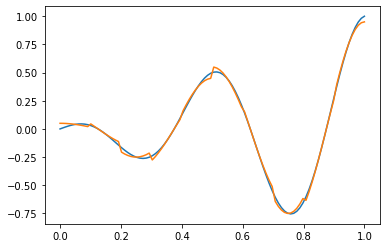

In [45]:
# plot the signal and the discretized version when keeping the carrier analog
sig.draw(0, 1, 100)
disc1.draw(0, 1, 100)

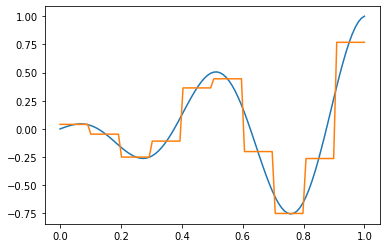

In [46]:
# plot the signal and the discretized version when also sampling the carrier
sig.draw(0, 1, 100)
disc2.draw(0, 1, 100)

The same can be done with `DiscreteSignalSum`.

In [47]:
sig1 = Signal(lambda t: t, carrier_freq=2.)
sig2 = Signal(lambda t: 1j * t**2, carrier_freq=3.)
sig_sum = sig1 + sig2

disc1 = DiscreteSignalSum.from_SignalSum(sig_sum, dt=0.1, start_time=0., n_samples=10)
disc2 = DiscreteSignalSum.from_SignalSum(sig_sum, dt=0.1, start_time=0., n_samples=10, sample_carrier=True)

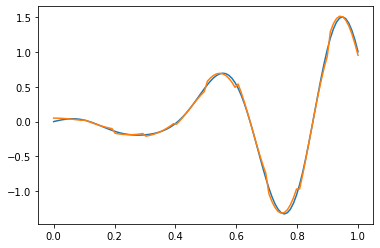

In [48]:
sig_sum.draw(0, 1, 100)
disc1.draw(0, 1, 100)

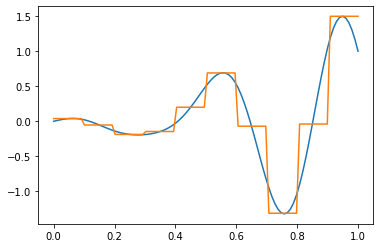

In [49]:
sig_sum.draw(0, 1, 100)
disc2.draw(0, 1, 100)